# #Project: we rate dogs 

In [ ]:
#to install tweepy and wordcloud libraries i installed them on anaconda prompt by typing pip install (name of library)
# Here we import all the packages to use througout the report
import pandas as pd
import numpy as np
import os.path
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
import requests
import json
import datetime
import re
import warnings
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [20]:
#change directory to find the downloaded files
os.chdir('C:\\Users\\correap\\Downloads')


# Gathering

We are going to have 3 tables to play with first one is image_predictions, secodn is from the twiter archive and thrid from twiter website

In [624]:
# Use requests library to download tsv file from a website
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)

# Read in tsv file as a Pandas DataFrame    
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

In [625]:
#this is the twitter_acrchive provided by Udacity
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [6]:
#save these things for project from tweepy website
consumer_key = '9q8o7zfTJJZvN4Cwevjh7SqTu'
consumer_secret = 'aAMht27vw75zMBlEZPmd1uPE4AYwlN7Tbk1yGMJQl7zwHyuUmb'
access_token = '1052722791060054017-ZPq1DiAkbxmOVwbagNt7YIXlf4Qyke'
access_secret = 'NteZ8nisebbxZdhzVITuDIvqpkI4SdWqwTlZPvVnkum66'


In [17]:
#this is the begingin for accesing the tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [23]:
# For loop which will add each available tweet to a new line of tweet_json.txt
#this also matches the tweet_id from the twitter archive onto the tweet API data
with open('tweet_json.txt', 'a', encoding='utf8') as f:
    for tweet_id in twitter_archive['tweet_id']:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, f)
            f.write('\n')
        except:
            continue

Rate limit reached. Sleeping for: 719
Rate limit reached. Sleeping for: 711


In [635]:
# For loop to append each tweet into a list
tweets_data = []
tweet_file = open('tweet_json.txt', "r")
for line in tweet_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue
tweet_file.close()

In [636]:
# Create tweet_API DataFrame to add onto the tweets_data information
tweet_API = pd.DataFrame()
# Add selected variables to tweet_info DataFrame
tweet_API['id'] = list(map(lambda tweet: tweet['id'], tweets_data))
tweet_API['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweets_data))
tweet_API['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'], tweets_data))

# ASSES

QUality issues gropued by types:

-completeness:
   -in twiter_archive ONLY 425 dogs clasified by stage so we can try to extract the other dog stages from the text data
    -there is missiing data with incorrect values (none should be listed as NAN types) for the names in archive data
    -There are tweets with same jpg url in the image_prediction data... need to get rid of these
        
-validity:
  -change the 'id' key to 'tweet id' so that it is uniform in all tables
   -the rating numerator and denominator have a couple issues:
           -denominator has some values higher than 10
           -some tweets have 2 ratings. Usually second rating is correct one         
   
-consistency: units, etc
   -names of the dogs are very inconsistent. Some have a, the, etc
   -the tweet id type should be string for all as we dont want operations on these
    -The date on archicve timestamp needs to be changed to datetime type data
    -Have the text display all of it so we can see data easier
    
Tidiness issues:
  -The dog stage should be in one column and not 4 separate ones
   -Image_prediction, API and archive data should be in the same table
   -Remove unecessary columns in the final table
    

In [318]:
#Look at the API data
tweet_API.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 3 columns):
tweet_id          2341 non-null int64
retweet_count     2341 non-null int64
favorite_count    2341 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


In [27]:
#Look at the API data
tweet_API.head()

,id,retweet_count,favorite_count
0,892420643555336193,8404,38295
1,892177421306343426,6198,32826
2,891815181378084864,4099,24725
3,891689557279858688,8536,41643
4,891327558926688256,9253,39816


In [110]:
#check to see if API data has missing values
sum(tweet_API.favorite_count.isnull())
sum(tweet_API.retweet_count.isnull())

0

In [28]:
#here we inspect the image predictions df
image_predictions.head()


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [33]:
#here we inspect the image predictions df
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [626]:
#here we look at twitter_archive adn notice that the Name has several Nones
twitter_archive.tail(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None


In [629]:
#the names of some dogs are not correctly displayed so this might need to be omitted or extracted from the text eventually
twitter_archive['name'].value_counts()

None         745
a            55 
Charlie      12 
Oliver       11 
Cooper       11 
Lucy         11 
Tucker       10 
Penny        10 
Lola         10 
Winston      9  
Bo           9  
Sadie        8  
the          8  
Buddy        7  
Toby         7  
Bailey       7  
Daisy        7  
an           7  
Jax          6  
Oscar        6  
Koda         6  
Scout        6  
Leo          6  
Jack         6  
Dave         6  
Bella        6  
Milo         6  
Stanley      6  
Rusty        6  
Sammy        5  
            ..  
River        1  
Steve        1  
Amy          1  
Pancake      1  
Timofy       1  
Beckham      1  
Rolf         1  
Randall      1  
Mookie       1  
Dudley       1  
Vinscent     1  
Acro         1  
Molly        1  
Craig        1  
Mingus       1  
Dylan        1  
Theo         1  
Evy          1  
Nida         1  
Zara         1  
Poppy        1  
Jessifer     1  
Lucky        1  
Bowie        1  
Divine       1  
Kramer       1  
Sojourner    1  
Snoop        1

In [79]:
#lets inspect the rating_numerator and rating_denominator... there are several out of range values here
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [80]:
#lets inspect the rating_numerator and rating_denominator... there are several out of range values here
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [257]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [70]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [87]:
#here we inspect tht text randominly
twitter_archive['text'].sample(10)

2211    Here is a horned dog. Much grace. Can jump ove...
387     I was going to do 007/10, but the joke wasn't ...
23      This is Canela. She attempted some fancy porch...
2061    This is Herm. It's his first day of potty trai...
1384    This is Daniel. He's a neat pup. Exotic af. Cu...
739     Meet Hercules. He can have whatever he wants f...
2127    AT DAWN...\nWE RIDE\n\n11/10 https://t.co/QnfO...
555     RT @dog_rates: I present to you... Dog Jesus. ...
1859    Meet Reggie. He's going for the world record. ...
382     RT @dog_rates: This is Phil. He's an important...
Name: text, dtype: object

In [67]:
#here we asses how many of the rows have a valid name of puppo, doggo, floofer...etc so we can how what we are missing 
puppo=(twitter_archive['puppo'].value_counts()[1])
doggo=(twitter_archive['doggo'].value_counts()[1])
floofer=(twitter_archive['floofer'].value_counts()[1])
pupper=(twitter_archive['pupper'].value_counts()[1])
puppo=(twitter_archive['puppo'].value_counts()[1])
totals=puppo+doggo+floofer+pupper+puppo
totals

424

In [34]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [53]:
#LETS see if there are duplicates in the twitter-archive

twitter_archive[twitter_archive['tweet_id'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [93]:
#LETS see if there are duplicates in the API

tweet_API[tweet_API['id'].duplicated()]

,id,retweet_count,favorite_count


In [89]:
#LETS see if there are duplicates in the image_predictions
image_predictions['tweet_id'].duplicated().value_counts()

False    2075
Name: tweet_id, dtype: int64

In [94]:
#here we inspect hte image_precition dataset focusing on the jpg_url
image_predictions['jpg_url'].value_counts()

https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg                                            2
https://pbs.twimg.com/media/CvyVxQRWEAAdSZS.jpg                                            2
https://pbs.twimg.com/media/Cs_DYr1XEAA54Pu.jpg                                            2
https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg                                            2
https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg                                            2
https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg                                            2
https://pbs.twimg.com/media/C2kzTGxWEAEOpPL.jpg                                            2
https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg                                            2
https://pbs.twimg.com/media/Ct72q9jWcAAhlnw.jpg                                            2
https://pbs.twimg.com/media/Ck2d7tJWUAEPTL3.jpg                                            2
https://pbs.twimg.com/tweet_video_thumb/CeBym7oXEAEWbEg.jpg           

In [100]:
#we check that there is no missing data as far as url goes
sum(image_predictions.jpg_url.isnull())

0

In [106]:
#sampling the image_predictions
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
673,683357973142474752,https://pbs.twimg.com/media/CXvGbWeWMAcRbyJ.jpg,1,Pembroke,0.406509,True,Cardigan,0.154854,True,Siberian_husky,0.136366,True
1329,757596066325864448,https://pbs.twimg.com/media/CoOFmk3WEAAG6ql.jpg,1,doormat,0.845256,False,wallet,0.095718,False,wool,0.026072,False
1008,709207347839836162,https://pbs.twimg.com/media/CdecUSzUIAAHCvg.jpg,1,Chihuahua,0.948323,True,Italian_greyhound,0.017730,True,quilt,0.016688,False
849,695629776980148225,https://pbs.twimg.com/media/Cadfl6zWcAEZqIW.jpg,1,Old_English_sheepdog,0.693857,True,otterhound,0.232117,True,West_Highland_white_terrier,0.012867,True
373,672988786805112832,https://pbs.twimg.com/media/CVbvjKqW4AA_CuD.jpg,1,Lakeland_terrier,0.836632,True,West_Highland_white_terrier,0.073900,True,wire-haired_fox_terrier,0.038160,True


In [98]:
#here we copy the first jpg_url and see that there is repetition or the url for 2 different tweet IDs
image_predictions[image_predictions['jpg_url'] == 'https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
587,679062614270468097,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True


In [69]:
# Sort values of 'name' column alphabetically - lowercase values appear at the bottom
twitter_archive.name.sort_values()

1035            Abby
1021            Abby
938              Ace
1933            Acro
1327           Adele
1934           Aiden
77               Aja
480            Akumi
820               Al
875           Albert
1954          Albert
144            Albus
412            Albus
1115         Aldrick
2046       Alejandro
374        Alexander
1189    Alexanderson
486              Alf
2238           Alfie
661            Alfie
367            Alfie
1616           Alfie
858            Alfie
51              Alfy
201            Alice
1701           Alice
1495           Amber
1334         Ambrose
2078             Amy
2195          Amélie
            ...     
852               my
988              not
335              not
1747      officially
1206             old
993              one
1936             one
924              one
369              one
2326           quite
169            quite
118            quite
193            quite
2030           space
22              such
2345             the
2346         

In [632]:
#here we see what the keys are for our twitter_archive data
list(twitter_archive)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [633]:
#here we see what the keys are for our image_prediction data
list(image_predictions)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

In [637]:
#here we see what the keys are for our tweet_API
list(tweet_API)

['id', 'retweet_count', 'favorite_count']

In [631]:
# View all occurences where there are more than one #/# in 'text' column
twitter_clean[twitter_clean.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")]

C:\Users\correap\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stageC,dog_stage,clean_text_2,new_num
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17.0,10.0,NaN,NaN,NaN,13/10,13
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960.0,0.0,NaN,NaN,NaN,13/10,13
561,802624713319034886,NaN,NaN,2016-11-26 21:26:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: ""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",7.776842e+17,4.196984e+09,2016-09-19 01:42:24 +0000,"https://twitter.com/dog_rates/status/777684233540206592/photo/1,https://twitter.com/dog_rates/status/777684233540206592/photo/1",12.0,10.0,NaN,pupper,pup,11/10,11
766,777684233540206592,NaN,NaN,2016-09-19 01:42:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",NaN,NaN,NaN,https://twitter.com/dog_rates/status/777684233540206592/photo/1,12.0,10.0,NaN,pupper,pup,11/10,11
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9.0,11.0,NaN,NaN,NaN,14/10,14
860,763167063695355904,NaN,NaN,2016-08-10 00:16:21 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Eve. She's a raging alcoholic 8/10 (would b 11/10 but pupper alcoholism is a tragic issue that I can't condone) https:/…,6.732953e+17,4.196984e+09,2015-12-06 00:17:55 +0000,https://twitter.com/dog_rates/status/673295268553605120/photo/1,8.0,10.0,Eve,pupper,pupper,11/10,11
1007,747600769478692864,NaN,NaN,2016-06-28 01:21:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/747600769478692864/photo/1,https://twitter.com/dog_rates/status/747600769478692864/photo/1",10.0,10.0,Bookstore,NaN,NaN,7/10,7
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9.0,11.0,NaN,NaN,NaN,14/10,14
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 f

In [241]:
#here we see what the keys are for our API_clean data... I noticed that the API_clean needs to have unifor tweet_ID changed
list(API_clean)

['id', 'retweet_count', 'favorite_count']

# Cleaning

In [218]:
#first we make a copy of all dataframes
twitter_clean = twitter_archive.copy()
image_clean = image_predictions.copy()
API_clean = tweet_API


In [283]:
 #Create 'dog_stage' variable which is made by extracting the dog stage variables from the text column when available
#as many of the columns are empty I am picking several names taht will make it better
twitter_clean['dog_stage'] = twitter_clean['text'].str.extract('(puppo|nose|pupper|floofer|doggo|blep|snoot|floof|oggo|uppo|pupp|puppo|floof|loof|floofr|loofer|flof|floofer|oggo|dogg|doggo|bleep|pup)',                                                           
                                                               expand=True).copy()

In [287]:
# Loop on all the texts and check if it has one of pronouns of male or female
# and append the result in a list
dog_stageC = []

for dog_stage in twitter_clean['dog_stage']:
    # doggo
    if any ([dog_stage=='doggo',dog_stage=='oggo',dog_stage=='dogg']) :
        dog_stageC.append('doggo')
    # pupper
    elif any([dog_stage=='pup',dog_stage=='pupper']) :
        dog_stageC.append('pupper')
    #puppo    
    elif any([dog_stage=='puppo',dog_stage=='pupp',dog_stage=='uppo']) :
        dog_stageC.append('puppo')
    #floofer
    elif any([dog_stage=='floof',dog_stage=='loof',dog_stage=='floofer']) :
        dog_stageC.append('floofer')
    #blep
    elif any([dog_stage=='blep']) :
        dog_stageC.append('blep')
    #snoot
    elif any([dog_stage=='nose',dog_stage=='snoot']) :
        dog_stageC.append('snoot')
      
      
   # If group or not specified
    else:
        dog_stageC.append('NaN')
#save it
# Save the result in a new column 'dog_name'
twitter_clean['dog_stageC'] = dog_stageC


In [288]:
#checking that the above worked
twitter_clean['dog_stageC'].value_counts()

NaN        1661
pupper      480
doggo       104
puppo        60
floofer      39
snoot        11
blep          1
Name: dog_stageC, dtype: int64

In [222]:
# Create variable of columns that are no longer needed and drop them from the DataFrame 
columns = ['doggo', 'floofer', 'pupper', 'puppo','dog_stage']
twitter_clean = twitter_clean.drop(columns, axis=1)

DEfine: Change the names from NOne to NaN

In [ ]:
#CODE:
#change name to NaN
twitter_clean['name'] = twitter_clean['name'].replace('None', np.NaN)

In [252]:
#TEST
twitter_clean['name'].tail()

2351    NaN
2352      a
2353      a
2354      a
2355    NaN
Name: name, dtype: object

Define:  drop the duplicated jpg_urls in the image_clean

In [225]:
#CODE:
#get rid of duplicate data in image predictions with urls duplicated
image_clean['jpg_url'].drop_duplicates(inplace=True)

In [247]:
#TEST
#lets see value counts for jpg_url now
image_clean['jpg_url'].value_counts()

https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg                                            1
https://pbs.twimg.com/media/CY8SocAWsAARuyh.jpg                                            1
https://pbs.twimg.com/media/CUELa0NUkAAscGC.jpg                                            1
https://pbs.twimg.com/media/CU67jGSUkAAk_1Y.jpg                                            1
https://pbs.twimg.com/media/CUXDGR2WcAAUQKz.jpg                                            1
https://pbs.twimg.com/media/Ct2qO5PXEAE6eB0.jpg                                            1
https://pbs.twimg.com/media/C7iNfq1W0AAcbsR.jpg                                            1
https://pbs.twimg.com/media/CURiQMnUAAAPT2M.jpg                                            1
https://pbs.twimg.com/media/CU8XW2dWwAA-Lmc.jpg                                            1
https://pbs.twimg.com/media/DD-40X3WAAAJPU5.jpg                                            1
https://pbs.twimg.com/media/Cop9VVUXgAAhX9u.jpg                       

Define: change the 'id' key in tweet_API to 'tweet_id' for consistency with other dataframes

In [245]:
#CODE
#change the key in the tweet_API from id to tweet_id
tweet_API.rename(columns={'id': 'tweet_id'}, inplace=True)

In [248]:
#TEST
list(tweet_API)

['tweet_id', 'retweet_count', 'favorite_count']

In [ ]:
Define: chnage the display column width so that we can observe the text better

In [ ]:
#CODE
#Before contining I want to see the whole txt so ths function will help with this
pd.set_option('display.max_colwidth', -1)

In [639]:
#TEST
twitter_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stageC,dog_stage,clean_text_2,new_num
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,NaN,NaN,13/10,13


Define: correct the rating numerator and denominator ranges. there are more thann one #/# in the text. Usually the last one of the 2 ratings is the correct one

In [458]:
#CODE
#here we create the better_cleaning definition so that we can interate find the last appearance of '/10' and return the '#/#'
#if there is no number it would return NaNs
def better_cleaning(tweet):
    #we run the try so that it can bypass the NaNs
    try:
        start, end = list(re.finditer('/10', tweet))[-1].span()
        return tweet[start-2:end]
    except:
        return 'NaN'

In [468]:
#Here we call on the definition from above and save it in a new column
twitter_clean['clean_text_2'] = twitter_clean['text'].apply(lambda x: better_cleaning(x))


In [641]:
#Here we extracT the numbers in the clean_text_2 and put them to new_num
twitter_clean['new_num']=twitter_clean['clean_text_2'].str.extract('(\d+)')
#then drop the lines where NaN where found 
twitter_final=twitter_clean[twitter_clean.new_num.notnull()]
#then convert to int and divide by 10 as this is correct numerator
twitter_final['rating_ratio']=(twitter_final['new_num'].astype('int'))/10

C:\Users\correap\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
C:\Users\correap\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [642]:
#TEST
#check the rating_ratio column
twitter_final['rating_ratio'].head()

0    1.3
1    1.3
2    1.2
3    1.3
4    1.2
Name: rating_ratio, dtype: float64

#Define:CHange the datetime of archive to dateime datatype

In [643]:
#CODE
#here we do the transformation to datetime
twitter_final['timestamp'] = pd.to_datetime(twitter_final['timestamp'])

C:\Users\correap\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [644]:
#TEST
twitter_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2340 non-null int64
in_reply_to_status_id         74 non-null float64
in_reply_to_user_id           74 non-null float64
timestamp                     2340 non-null datetime64[ns]
source                        2340 non-null object
text                          2340 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2284 non-null object
rating_numerator              2340 non-null float64
rating_denominator            2340 non-null float64
name                          1608 non-null object
dog_stageC                    2340 non-null object
dog_stage                     685 non-null object
clean_text_2                  2340 non-null object
new_num                       2340 non-null object
rating_ratio         

#Define: fix dog names formats

In [503]:
# create columns that contains the words 'name is'
named_to_replace = twitter_final.loc[(twitter_final['name'].str.islower()) & (twitter_final['text'].str.contains('named'))]
name_is_to_replace = twitter_final.loc[(twitter_final['name'].str.islower()) & (twitter_final['text'].str.contains('name is'))]
# Save these locations as lists
named_to_replace_list = named_to_replace['text'].tolist()
name_is_to_replace_list = name_is_to_replace['text'].tolist()
# For loop to iterate through locations where name is lowercase and the words 'named' appear in 'text' and set the 'name' 
# value to be the word that appears after 'named'
for entry in named_to_replace_list:
    mask = twitter_final.text == entry
    name_column = 'name'
    twitter_final.loc[mask, name_column] = re.findall(r"named\s(\w+)", entry)

# For loop to iterate through locations where name is lowercase and the words 'name is' appear in 'text' and set the 'name' 
# value to be the word that appears after 'name is'    
for entry in name_is_to_replace_list:
    mask = twitter_final.text == entry
    name_column = 'name'
    twitter_final.loc[mask, name_column] = re.findall(r"name is\s(\w+)", entry) 

C:\Users\correap\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [646]:
#TEST
#here we can see that we fixed the last ones by assigning it Nans
twitter_final.name.sort_values()

1021    Abby        
1035    Abby        
938     Ace         
1933    Acro        
1327    Adele       
1934    Aiden       
77      Aja         
480     Akumi       
820     Al          
1954    Albert      
875     Albert      
412     Albus       
144     Albus       
1115    Aldrick     
2046    Alejandro   
374     Alexander   
1189    Alexanderson
486     Alf         
661     Alfie       
858     Alfie       
1616    Alfie       
2238    Alfie       
367     Alfie       
51      Alfy        
201     Alice       
1701    Alice       
1495    Amber       
1334    Ambrose     
2078    Amy         
2195    Amélie      
         ...        
2294    NaN         
2298    NaN         
2299    NaN         
2301    NaN         
2305    NaN         
2306    NaN         
2307    NaN         
2310    NaN         
2316    NaN         
2320    NaN         
2321    NaN         
2322    NaN         
2323    NaN         
2324    NaN         
2328    NaN         
2329    NaN         
2330    NaN  

#Define: Join 'tweet_info' and 'image_predictions' to 'twitter_archive'

In [524]:
#Here we join with API
twitter_final = pd.merge(left=twitter_final, right=API_clean, left_on='tweet_id', right_on='tweet_id', how='inner')


In [525]:
#Here we join with image_predictions
twitter_final = twitter_final.merge(image_clean, on='tweet_id', how='inner')

In [528]:
#TETS
#we see that more rows were added
list(twitter_final)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stageC',
 'dog_stage',
 'clean_text_2',
 'new_num',
 'year',
 'retweet_count_x',
 'favorite_count_x',
 'retweet_count_y',
 'favorite_count_y',
 'retweet_count',
 'favorite_count',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

#define: change tweet ID to s tring type

In [530]:
#code:
twitter_final['tweet_id']=twitter_final['tweet_id'].astype('str')

In [531]:
#TEST
twitter_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2054 entries, 0 to 2053
Data columns (total 35 columns):
tweet_id                      2054 non-null object
in_reply_to_status_id         22 non-null float64
in_reply_to_user_id           22 non-null float64
timestamp                     2054 non-null datetime64[ns]
source                        2054 non-null object
text                          2054 non-null object
retweeted_status_id           74 non-null float64
retweeted_status_user_id      74 non-null float64
retweeted_status_timestamp    74 non-null object
expanded_urls                 2054 non-null object
rating_numerator              2054 non-null float64
rating_denominator            2054 non-null float64
name                          1490 non-null object
dog_stageC                    2054 non-null object
dog_stage                     598 non-null object
clean_text_2                  2054 non-null object
new_num                       2054 non-null float64
year                  

Define: make the final table cleaner by removing  unnecessary columns

In [541]:
#CODE
#Drop unecessary columns
columns = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp','rating_numerator'
           ,'rating_denominator','dog_stage']
twitter_final = twitter_final.drop(columns, axis=1)

In [543]:
#TEST
list(twitter_final)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'name',
 'dog_stageC',
 'clean_text_2',
 'new_num',
 'year',
 'retweet_count_x',
 'favorite_count_x',
 'retweet_count_y',
 'favorite_count_y',
 'retweet_count',
 'favorite_count',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

# VISUALIZE

In [290]:
#counts for the graph below from dog_stageC
twitter_clean['dog_stageC'].value_counts()

NaN        1661
pupper      480
doggo       104
puppo        60
floofer      39
snoot        11
blep          1
Name: dog_stageC, dtype: int64

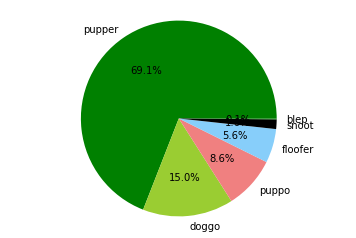

In [292]:
# pie chart of workers
labels = ['pupper', 'doggo', 'puppo', 'floofer','snoot','blep']
#these I input manualy from the clean data
sizes = [480,104,60,39,11,1]
colors = ['green', 'yellowgreen', 'lightcoral', 'lightskyblue','black']
# print(sizes) # adds up to 1433, which is the total number of participants
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',colors=colors)
ax1.axis('equal')
plt.show()

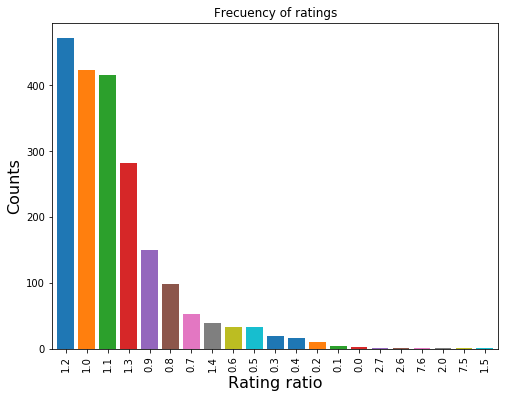

In [620]:
#Plot the rating Frecuency
twitter_final['new_num'].value_counts().plot(kind='bar',
                                             title='Frecuency of ratings',figsize=(8, 6), width=0.8, legend=False,alpha=1);
plt.xlabel('Rating ratio',fontsize=16);
plt.ylabel('Counts',fontsize=16);

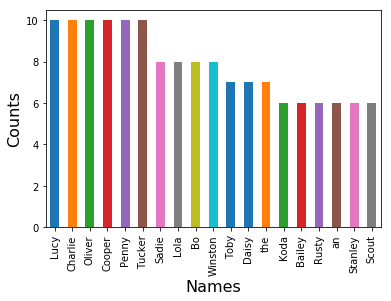

In [622]:
#(twitter_final['name'].value_counts()).nlargest(11, 'name')
a=pd.value_counts(twitter_final['name'])
a[1:20].plot.bar()
plt.xlabel('Names',fontsize=16);
plt.ylabel('Counts',fontsize=16);

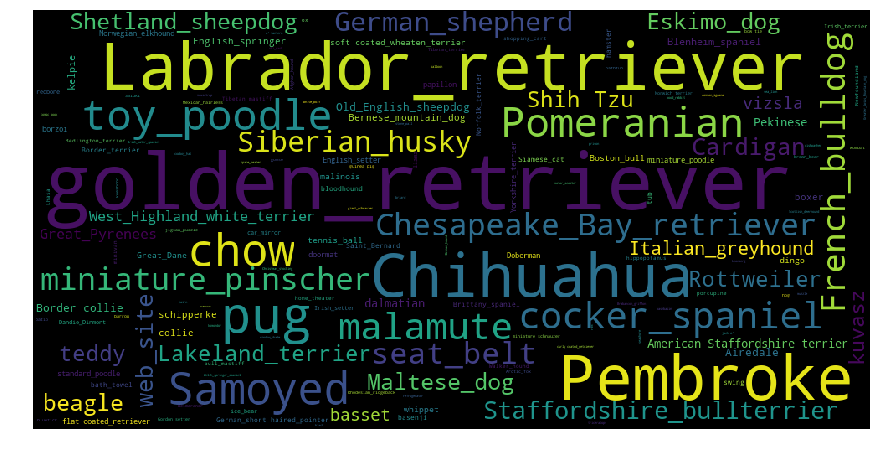

In [558]:
#convert list to string and generate dog_type from the highest image_prediction p1
#here we are using the wordcloud library
dog_type=twitter_final['p1']
unique_string=(" ").join(dog_type)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [623]:
#here we group by year and month from the timestamp info, then we get the median and count from grouped coluns
#we save these computations in the twitter_time df
twitter_time = twitter_final.groupby([twitter_final['timestamp'].dt.year,twitter_final['timestamp'].dt.month]).agg(['median','count'])

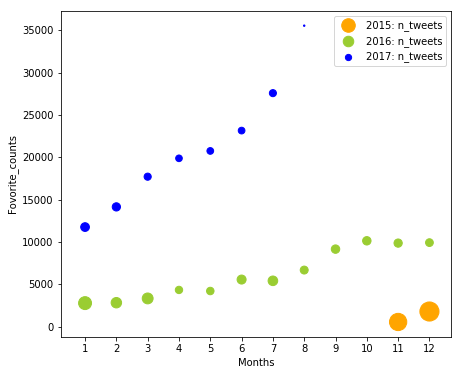

In [640]:
#here we plot the meadian of likes against tweet counts per month/year where the dots are proportional to the tweets
ax = twitter_time['favorite_count'].loc[2015].reset_index().plot.scatter(x ='timestamp',y='median',c='orange',s=visual['favorite_count','count'] , xticks=range(1,13), label='2015: n_tweets')
ax1 = twitter_time['favorite_count'].loc[2016].reset_index().plot.scatter(x ='timestamp',y='median',c='yellowgreen',s=visual['favorite_count','count'].loc[2016] , xticks=range(1,13),label='2016: n_tweets',ax=ax )
twitter_time['favorite_count'].loc[2017].reset_index().plot.scatter(x ='timestamp',y='median',c='blue',s=visual['favorite_count','count'].loc[2017], xticks=range(1,13),label='2017: n_tweets',ax=ax1,figsize=(7, 6) )
ax.set(xlabel='Months', ylabel='Fovorite_counts')
plt.show()